Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos <br>
Primer Semestre 2025
<br>

<h1><center>Tarea 2: Isolation Forest, HAC, DBSCAN y HDBSCAN </center></h1>
<h3><center>Tomás Romero Aránguiz </center></h3>

        Profesor: Marcelo Mendoza<br>
        Ayudantes encargados: Itzae Flores, Claudia González y Eduardo Salinas.<br>
        Fecha de entrega: 23 de abril del 2025.

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- Para las preguntas de desarrollo se espera un análisis profundo, no una respuesta superficial.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [180]:
##Importa acá las librerias que vayas a utilizar
## De ser necesario, utiliza el comando !pip install a aquellas librerias o modulos que no se encuentren instalados, como puede ser HDBSCAN.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from random import random
from matplotlib import pyplot as plt    

from scipy.cluster.hierarchy import dendrogram
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, minmax_scale
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN, cluster_optics_dbscan
from sklearn.ensemble import IsolationForest
# from sklearn.cluster import , HDBSCAN
from sklearn.mixture import GaussianMixture




El siguiente codigo sirve para importar HDBSCAN en el caso de que les arroje error importar desde sklearn.

In [181]:
# from hdbscan import HDBSCAN

# Introducción

El conjunto de datos corresponde a características extraidas de imagenes de distintos clientes que están buscando pedir un crédito a un banco. Se trabaja con este dataset para predecir si el cliente aceptó o no el último préstamo ofrecido (dado por la columna "Personal Loan") por medio del uso de HAC, DBSCAN, HDBSCAN e Isolation Forest.

En esta tarea deberás trabajar con el dataset Imbalanced Personal Bank Loan Classification que puedes descargar de [Kaggle] (https://www.kaggle.com/code/farzadnekouei/imbalanced-personal-bank-loan-classification) o Canvas.

# Parte 1: Carga y Preprocesamiento de Datos (10 puntos)

En esta primera parte se debe cargar el dataset y luego describir el comportamiento de algunas variables de interés. Posteriormente, debe realizar el proceso de normalización de los datos.

### 1.1 Carga de datos (1 puntos)

In [182]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [183]:
descripcion = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Description', header=None)
descripcion = descripcion[[1,2]]
descripcion.dropna(inplace=True)

### 1.2 Descripcion del Dataset (5 puntos)

#### 1.2.1 Describa brevemente cuantas columnas tiene el dataset y en que consisten las columna del dataset entregado (1 puntos)

In [184]:
print(df.shape)
for fila in descripcion.iterrows():
    print(f"{fila[1][1].upper()}: {fila[1][2]}")

(5000, 14)
ID: Customer ID
AGE: Customer's age in completed years
EXPERIENCE: #years of professional experience
INCOME: Annual income of the customer ($000)
ZIPCODE: Home Address ZIP code.
FAMILY: Family size of the customer
CCAVG: Avg. spending on credit cards per month ($000)
EDUCATION: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
MORTGAGE: Value of house mortgage if any. ($000)
PERSONAL LOAN: Did this customer accept the personal loan offered in the last campaign?
SECURITIES ACCOUNT: Does the customer have a securities account with the bank?
CD ACCOUNT: Does the customer have a certificate of deposit (CD) account with the bank?
ONLINE: Does the customer use internet banking facilities?
CREDITCARD: Does the customer use a credit card issued by UniversalBank?


**Respuesta:** 
El dataset cuenta con 14 columnas, las cuales son:
- **ID**: Identificador único.
- **AGE**: Edad.
- **EXPERIENCE**: Años de experiencia profesional.
- **INCOME**: Ingreso anual (en miles de dólares).
- **ZIPCODE**: Código postal del domicilio.
- **FAMILY**: Tamaño del grupo familiar.
- **CCAVG**: Gasto promedio mensual en tarjetas de crédito (en miles de dólares).
- **EDUCATION**: Nivel educativo. 1: Pregrado; 2: Posgrado; 3: Avanzado/Profesional.
- **MORTGAGE**: Valor de la hipoteca de la vivienda, si existe (en miles de dólares).
- **PERSONAL LOAN**: ¿Aceptó el préstamo personal ofrecido en la última campaña?
- **SECURITIES ACCOUNT**: ¿Tiene cuenta de valores con el banco?
- **CD ACCOUNT**: ¿Tiene cuenta de certificado de depósito (CD) con el banco?
- **ONLINE**: ¿Usa servicios de banca por internet?
- **CREDITCARD**: ¿Usa tarjeta de crédito emitida por UniversalBank?


1.2.2 ¿Es posible en este dataset eliminar columnas sin afectar de manera significativa los datos? ¿Por qué? (2 puntos)

**Respuesta:** Creo que es posible eliminar tres columnas sin afectar de manera significativa los datos. Estas serían el *ID*, *ZIPCODE* y *ONLINE*, porque no creo que sean relevantes para el modelo el identificador del cliente, su locación y si utiliza la banca online, ya que es irrelevante para los modelos quien es el cliente. El ZIPCODE, al menos que se haga un estudio geogrefico, no tendra mmucha relacion con nuestro objetivo. Y ONLINE ya que una persona de edad que no utilice estos medios será igual de responsable que otra que si lo utilice.

In [185]:
df = df.drop(columns=['ID', 'ZIP Code', 'Online'])

#### 1.2.3 ¿Por qué crees que es relevante trabajar estos datos? Averigua 3 posibles usos en que trabajar los datos de esta forma podría ser útil para problemas que resuelven las organizaciones (2 puntos)

**Respuesta:** Es importante trabajar con estos datos ya que nos poermite extraer informacion de comportamiento, perfiles y detectar anomalias en los clientes. Tres posibles usos en los que aplicar estos tratamientos de datos son:
- Segmentacion de clientes:  Se normalizan las features y se reduce la dimensionalidad, para luego crear clusters evitando sesgos. Esto permite crear grupos para campañas personalizadas.
- Detección de Fraudes: Se aplican algortimos como Isolation Forest para analizar comportamientos atipicos y transacciones, normalizando datos y filtrando ruido. Se utiliza para identificar patrones sospechosos.
- Gestion de riesos crediticios: Se depuran outliers y se cosifican las variables categorias antes de utilizar HDBSCAN para perfilar clientes segun su riesgo. Clasifica a los solicitantes de prestamos en diferentes grupos basados en su historial y comportamiento

### 1.3 Determinación de valores nulos (1 punto)

Determina si existen datos y/o valores nulos presentes en el dataset. En caso de que existan, realiza el tratamiento pertinente.

In [186]:
df.notna().sum()

Age                   5000
Experience            5000
Income                5000
Family                5000
CCAvg                 5000
Education             5000
Mortgage              5000
Personal Loan         5000
Securities Account    5000
CD Account            5000
CreditCard            5000
dtype: int64

**Respuesta:** Podemos ver que no hay datos nulos, por lo tanto no reciben este tratamiento

### 1.4 Manejo del Dataset (2 puntos)

Normaliza los valores de las columnas del dataset. ¿Por qué esto es importante para el análisis?

In [187]:
df[['Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']] = minmax_scale(df[['Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']])
df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,CreditCard
0,25,0.086957,0.189815,1.000000,0.16,1,0.000000,0,1,0,0
1,45,0.478261,0.120370,0.666667,0.15,1,0.000000,0,1,0,0
2,39,0.391304,0.013889,0.000000,0.10,1,0.000000,0,0,0,0
3,35,0.260870,0.425926,0.000000,0.27,2,0.000000,0,0,0,0
4,35,0.239130,0.171296,1.000000,0.10,2,0.000000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,29,0.130435,0.148148,0.000000,0.19,3,0.000000,0,0,0,0
4996,30,0.152174,0.032407,1.000000,0.04,1,0.133858,0,0,0,0
4997,63,0.913043,0.074074,0.333333,0.03,3,0.000000,0,0,0,0
4998,65,0.934783,0.189815,0.666667,0.05,2,0.000000,0,0,0,0


**Respuesta** Es importante  normalizar las columnas del dataset por  varias razones: Primero no permite reducir la escala de los datos a valores entre 0 y 1, lo que permite a los modelos ser mas eficientes y eficaces ya que muechas tecnias de ML con sensibles a las diferencias de escala. Tambien permite comparar los resultados con otros modelos, o combinarlos con otros dataset que se encuentre en distintas unidades. Por ejemplo al comparar o juntar con otra tabla o modelo que se haya entrenado con CLP en vez de USD, ya que al reducir estas variables a valore de entre 1 y 0, permite estas comparaciones.

# Parte 2: Isolation Forest (15 puntos)

### 2.1 Reduzca la cantidad de componente reteniendo el 95% de la varianza (1 punto)

In [188]:
pca = PCA(0.95)
X = pca.fit_transform(df)
X.shape

(5000, 1)

### 2.2 Utilizando 100 iTrees, cree una instancia de Isolation Forest. ¿Cuántos outliers detecta Isolation Forest y a qué clases verdaderas pertenecen? (3 puntos)

In [189]:
clf = IsolationForest(random_state=0, n_estimators=100)
clf.fit(X)

IsolationForest(random_state=0)

In [190]:
y_pred = clf.predict(X)  # Devuelve array con 1 (normal) y -1 (outlier)
print(len(X[y_pred == -1]))
X[y_pred == -1]

4003


array([[-20.3459281 ],
       [ -0.34168225],
       [ -6.34092513],
       ...,
       [ 17.67014586],
       [ 19.66644025],
       [-17.344504  ]])

In [191]:
outliers_mask = (y_pred == -1)  # Máscara booleana para outliers
outliers_classes = df.loc[outliers_mask, 'Personal Loan'].value_counts()
print("Clases verdaderas de los outliers:")
print(outliers_classes)

Clases verdaderas de los outliers:
Personal Loan
0    3610
1     393
Name: count, dtype: int64


3060 outliers con de la clase 0, No aceptaron un prestamo

318 outliers con de la clase 1, Si aceptaron un prestamo

### 2.3 ¿Como cambia el numero de de outliers detectados al variar el parametro ```contamination```? Utilize los valores ```[0.01, 0.05, 0.1, 0.2]``` (3 puntos)


In [192]:
resultados = []
for contamination in [0.01, 0.05, 0.1, 0.2]:
    print(f"\nContaminación: {contamination}")
    clf = IsolationForest(random_state=0, n_estimators=100, contamination=contamination).fit(X)
    y_pred = clf.predict(X)  # Devuelve array con 1 (normal) y -1 (outlier)
    print(f'Cantidad de Outliers:{len(X[y_pred == -1])}')
    outliers_mask = (y_pred == -1)  # Máscara booleana para outliers
    outliers_classes = df.loc[outliers_mask, 'Personal Loan'].value_counts()
    print(outliers_classes)
    print("_"*40)
    scores = clf.score_samples(X)
    resultados.append([clf, scores])


Contaminación: 0.01
Cantidad de Outliers:48
Personal Loan
0    48
Name: count, dtype: int64
________________________________________

Contaminación: 0.05
Cantidad de Outliers:249
Personal Loan
0    233
1     16
Name: count, dtype: int64
________________________________________

Contaminación: 0.1
Cantidad de Outliers:500
Personal Loan
0    445
1     55
Name: count, dtype: int64
________________________________________

Contaminación: 0.2
Cantidad de Outliers:999
Personal Loan
0    898
1    101
Name: count, dtype: int64
________________________________________


Respuesta: Podemos ver en los resultados, que a medida que aumenta la contaminacion, tambien aumentan la cantidad de outliers detectados

### 2.4 Grafique los "anomaly scores" e indique si se ve un umbral claro (2 puntos)

In [193]:
# Calcular scores de anomalía (más negativo = más anómalo)
anomaly_scores = clf.score_samples(X)  # Usa el último modelo entrenado (ej: contamination=0.01)

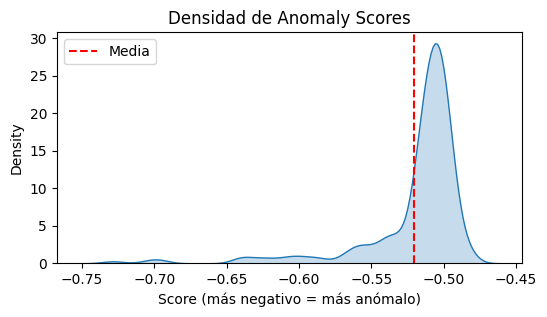

In [194]:
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.kdeplot(anomaly_scores, fill=True)
plt.title("Densidad de Anomaly Scores")
plt.xlabel("Score (más negativo = más anómalo)")
plt.axvline(x=np.mean(anomaly_scores), color='r', linestyle='--', label='Media')
plt.legend()
plt.show()

-0.5202024091996648


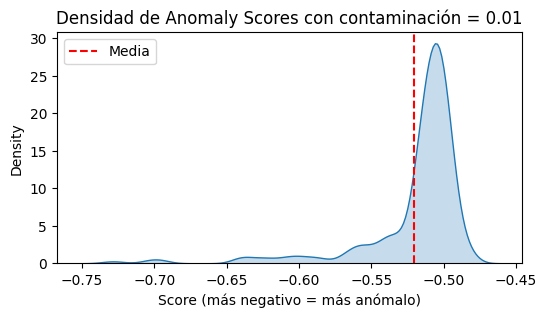

-0.5202024091996648


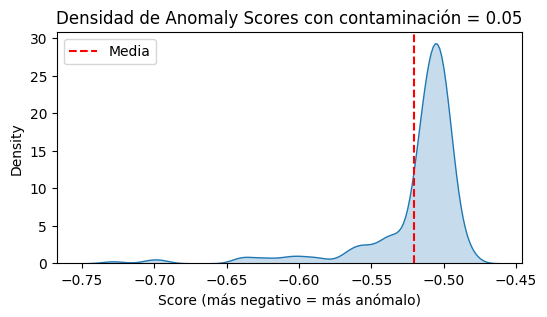

-0.5202024091996648


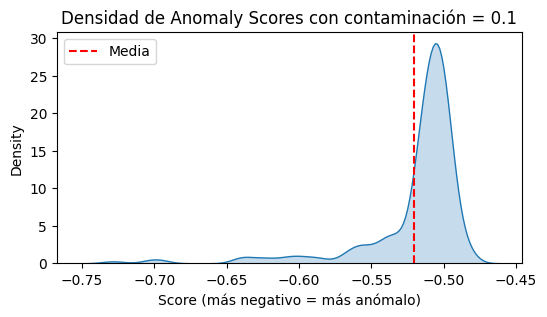

-0.5202024091996648


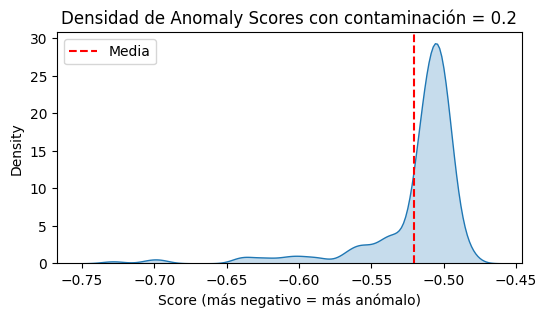

In [195]:
for r in resultados:
    clf = r[0]
    scores = r[1]
    contamination = clf.contamination
    plt.figure(figsize=(6, 3))
    sns.kdeplot(anomaly_scores, fill=True)
    plt.title("Densidad de Anomaly Scores con contaminación = {}".format(contamination))
    plt.xlabel("Score (más negativo = más anómalo)")
    plt.axvline(x=np.mean(scores), color='r', linestyle='--', label='Media')
    print(np.mean(scores))
    plt.legend()
    plt.show()

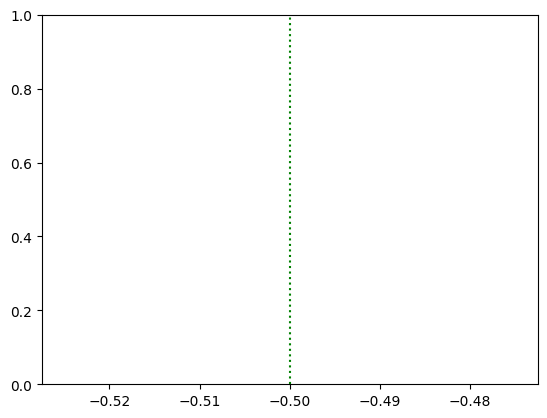

In [196]:
# Si hay bimodalidad, puedes marcar el umbral manualmente
threshold = -0.5  # Ejemplo: valores < -0.5 son outliers
plt.axvline(x=threshold, color='g', linestyle=':', label='Umbral propuesto')

### 2.5 Que tan estable es la detección de outliers si cambiamos la cantidad de arboles (```n_estimators```) (4 puntos)

### 2.6 Grafique los utliers detectados en las primeras dos componentes principales. (Utilize parametro ```alpha=0.6```) (2 puntos)

# Parte 3: HAC (15 puntos)

### 3.1 Reliza un dendograma sin clusters y con distancia threshold igual a 0 para visualizar los datos. Debes usar linkage = "single" (1 punto)

### 3.2.1 Realiza los Clustering de Agrupación Jerarquica (HAC) para cada distancia de clustering aglomerativo (linkage), prueba utilizando número de clusters entre 2 y 10. Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados. (2.5 puntos)
### 3.2.2 Ahora, realiza los Clustering de Agrupación Jerarquica (HAC) para cada tipo de linkage.

Se espera que expliquen cuál funcionó mejor

### 3.3 Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados, explicando cómo funciona cada linkage.


### 3.4 Grafica los clusters utilizando un PCA de 2 dimensiones de los datos. Para ello debes utilizar la mejor combinación del enunciado anterior(1 punto)






Con el análisis realizado, ¿Cuál es la importancia del criterio de vinculación al momento de agrupar los datos? Pruebe ahora utilizando solamente dos clusters y compare los graficos.

Deben explicar que el de 20 clusters se ve menos compacto y que los colores indican la cantidad de clusters, pudiendo ver más diferencias en el de 20.

# Parte 4: DBSCAN y HDBSCAN (15 puntos)

### 4.1.- DBSCAN

Utilizando DBSCAN, itera sobre valores de eps entre 0.25 y 2, con un salto de 0.25 por iteracion. Ademas, itera sobre el numero minimo de muestras, probando con 1, 2, 3 y 4. (3 puntos)

**RESPUESTA:**

#### 4.1.2 Con la información de los parametros anterior, calcula cual es el número de clusters óptimo para el modelo DBSCAN. (1.5 puntos)

**RESPUESTA:**

#### 4.1.3 Determine tambien el valor optimo del parametro `eps` y `min_samples` (0.5 puntos)

**RESPUESTA:**

#### 4.1.4 Obtenga el numero de clusters utilizando los parametros optimos encontrados. Explique por qué podría haber encontrado ese valor, el cual se puede o no ajustar al número de clases en el dataset. (1 puntos)

**RESPUESTA:**

Se espera un analisis de ajuste de datos a clusters contra las clases. Puntaje por analisis y justificacion.

### 4.2.- HDBSCAN

Utilizando HDSCAN, cree un modelo con el `cluster_selection_epsilon` igual al caso de DBSCAN y determine el número de clusters. Itere sobre el min_cluster_size para encontrar el mejor silhoutte score. Compare el resultado con DBSCAN.  (3 puntos)

**RESPUESTA:**

#### 4.2.2 Grafique los clusters utilizando PCA de 2 dimensiones. (1 punto)

**RESPUESTA:**

¿Que representa cada cluster?

**RESPUESTA:**

### 4.4 Preguntas teoricas sobre HAC, DBSCAN y HDBSCAN (5 puntos)

#### 4.4.1 En tus palabras, ¿Cómo funciona el Agglomerative Clustering? Además, menciona al menos 2 usos para HAC.

**RESPUESTA:**

#### 4.4.2 Explique que representa un dendograma, mencionando cómo las ramas principales podrían significar las clases del datset.

**RESPUESTA:**

#### 4.4.3 En el contexto del modelo DBSCAN, ¿Que es un core sample? ¿Que podría representar un core sample en términos de un dato en el dataset? Apóyese en la clases y sus características.

**RESPUESTA:**

#### 4.4.4 En el modelo de DBSCAN se iteran sobre distintos parametros; eps y min_samples. ¿Qué representan estos parametros?

**RESPUESTA:**

#### 4.4.5 ¿Cuál es la diferencia entre DBSCAN y HDBSCAN? ¿Qué beneficios existen de usar un modelo sobre el otro?

**RESPUESTA:**

**RESPUESTA:**

**Respuesta**

**Para esta sección, utilize el modelo con mejor silhouette score obtenido.**

# Parte 5: Comparación y eficiencia (5 puntos)

#### 5.1 ¿Cuál de los métodos de clustering resultó ser el más eficiente entre HAC, DBSCAN, HDBSCAN o Isolation Forest? Da una explicación de por qué se puede deber el resultado.

**Respuesta**